In [1]:
import warnings
warnings.filterwarnings("ignore")

ZERONLG_HOME = 'data/checkpoints'
MODEL = 'output/zeronlg-4langs-vc'

In [2]:
import os
REPO = os.path.dirname(os.path.realpath('.'))
os.chdir(REPO)
os.environ['ZERONLG_HOME'] = ZERONLG_HOME

In [3]:
DATA_PATH = 'data/finetune/flickr30k/'

en_zh_path = os.path.join(DATA_PATH, 'en-zh')
en_captions = open(os.path.join(en_zh_path, 'test.en'), 'r').read().strip().split('\n')
zh_captions = open(os.path.join(en_zh_path, 'test.zh'), 'r').read().strip().split('\n')
en2zh = {item[0].lower(): item[1] for item in zip(*[en_captions, zh_captions])}

en_captions = open(os.path.join(DATA_PATH, 'en-de', 'test.en'), 'r').read().strip().split('\n')

for i in range(len(en_captions)):
    # add a full stop to each sentence of en_captions
    en_captions[i] = (en_captions[i] + ' .') if not en_captions[i].endswith(' .') else en_captions[i]

de_captions = open(os.path.join(DATA_PATH, 'en-de', 'test.de'), 'r').read().strip().split('\n')
fr_captions = open(os.path.join(DATA_PATH, 'en-fr', 'test.fr'), 'r').read().strip().split('\n')

en2de = {item[0].lower(): item[1] for item in zip(*[en_captions, de_captions])}
en2fr = {item[0].lower(): item[1] for item in zip(*[en_captions, fr_captions])}

imageids = open(os.path.join(DATA_PATH, 'en-de', 'test_images.txt'), 'r').read().strip().split('\n')
en2rpath = {item[0].lower(): item[1].split('.')[0] for item in zip(*[en_captions, imageids])}

In [4]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from sklearn import manifold
from zeronlg import Framework
from zeronlg.models import Projector
import matplotlib as mpl
import numpy as np
import random
import torch.backends.cudnn as cudnn
import torch.nn.functional as F


markers = ['^', 's', '*', 'd', '+']

def get_normalized_feats(model_name, all_texts):
    model = Framework(model_name)

    modules = model.get_modules()
    keep_modules = []
    for module in modules:
        if isinstance(module, Projector):
            break
        keep_modules.append(module)

    model = Framework(modules=keep_modules)
    model = model.to(model._target_device)
    model.eval()

    all_feats = []
    for texts, name in zip(all_texts, names):
        feats = model.encode(texts, show_progress_bar=False, convert_to_tensor=True)
        feats = F.normalize(feats, dim=-1)
        all_feats.append(feats)

    return all_feats


def get_corrupted_normalized_feats(all_feats, names, noise_std=0.1, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.benchmark = True
    
    new_feats = []
    for feats, name in zip(all_feats, names):
        if noise_std > 0 and name.lower() != 'vision':
            feats = feats + (torch.randn(feats.shape).to(feats.device) * noise_std)
            feats = F.normalize(feats, dim=-1)
        new_feats.append(feats)
    return new_feats


def transform2D(all_feats, random_state=0):
    n_samples = all_feats[0].size(0)
    
    pca = manifold.TSNE(n_components=2, random_state=random_state)

    original_feats = torch.cat(all_feats, dim=0)
    transformed_feats = pca.fit_transform(original_feats.cpu().numpy())

    # a tuple of tensors, each of which has the shape (n_samples, 2)
    feats = torch.FloatTensor(transformed_feats).split(n_samples, dim=0)
    return feats
    

def get_feats(model_name, all_texts, names, random_state=0, seed=0, noise_std=0):
    feats = get_normalized_feats(model_name, all_texts)
    feats = get_corrupted_normalized_feats(feats, names, noise_std, seed)
    feats = transform2D(feats, random_state)
    return feats

In [5]:
import configs
import random
random.seed(0)

n_samples = 200
en_texts = random.sample(list(en2de.keys()), n_samples)
zh_texts = random.sample(list(en2zh.values()), n_samples)
de_texts = random.sample(list(en2de.values()), n_samples)
fr_texts = random.sample(list(en2fr.values()), n_samples)
image_paths = [os.path.join(configs.image_video_root['flickr30k'], rpath) 
               for rpath in random.sample(list(en2rpath.values()), n_samples)]
all_texts = [en_texts, zh_texts, de_texts, fr_texts, image_paths]
names = ['English', 'Chinese', 'German', 'French', 'Vision']

In [6]:
alpha = 0.5
model_list = [f'{ZERONLG_HOME}/distilbert-base-multilingual-cased', MODEL, MODEL]
noise_std_list = [0, 0, 0.1]

all_feats = []
for i, (model_name, noise_std) in enumerate(zip(model_list, noise_std_list)):
    feats = get_feats(model_name, all_texts, names, noise_std=noise_std)
    all_feats.append(feats)

2023-11-17 16:08:05 - Load pretrained SentenceTransformer: data/checkpoints/distilbert-base-multilingual-cased
2023-11-17 16:08:05 - No sentence-transformers model found with name data/checkpoints/distilbert-base-multilingual-cased. Creating a new one with MEAN pooling.


Some weights of the model checkpoint at data/checkpoints/distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-11-17 16:08:07 - Use pytorch device: cuda
2023-11-17 16:08:07 - Use pytorch device: cuda
2023-11-17 16:08:12 - Load pretrained SentenceTransformer: output/zeronlg-4langs-vc
2023-11-17 16:08:19 - Use pytorch device: cuda
2023-11-17 16:08:19 - decoder's input and output word embeddings are tied to encoder's word embeddings
2023-11-17 16:08:19 - Use pytorch device: cuda
2023-11-17 16:08:25 - Load pretrained SentenceTransformer: output/zeronlg-4langs-vc
2023-11-17 16:08:30 - Use pytorch device: cuda
2023-11-17 16:08:30 - decoder's input and output word embeddings are tied to encoder's word embeddings
2023-11-17 16:08:30 - Use pytorch device: cuda


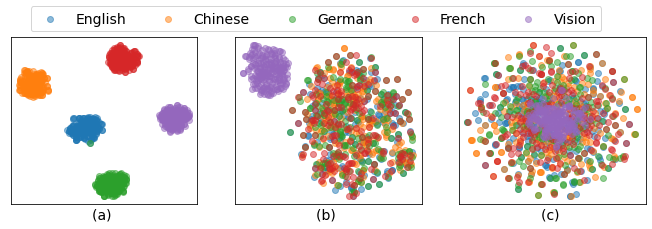

In [7]:
fig = plt.figure(figsize=(9, 3))

alias = ['', '', '']
for i in range(len(model_list)):
    ax = plt.subplot(1, len(model_list), i+1)

    feats = all_feats[i]
    
    for feat, name in zip(feats, names):
        ax.scatter(feat[:, 0], feat[:, 1], label=name, alpha=alpha)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f'({chr(97+i)}) {alias[i]}', fontsize=14)
    
    if i == 0:
        plt.legend(frameon=True, bbox_to_anchor=(3.2, 1.23), ncol=5, fontsize=14)

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.08, top=0.85, wspace=0.2)
# plt.savefig('tsne_visulization.png', dpi=300)